In [115]:
from package.HmmTSModel import HmmTimeSeriesModel
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
from matplotlib import cm
import plotly.express as px
import pandas as pd
import numpy as np
import scipy.stats as scs
from sklearn.mixture import GaussianMixture as GMM
import sklearn.mixture as mix
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import norm
from scipy.stats import poisson
import warnings
import seaborn as sns
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload
from package.HmmTSModel import HmmTimeSeriesModel

In [49]:
import yfinance as yf
from typing import List
from pandas_datareader import data as pdr

yf.pdr_override()
f1 = 'TEDRATE' # ted spread
f2 = 'T10Y2Y' # constant maturity ten yer - 2 year
f3 = 'T10Y3M' # constant maturity 10yr - 3m

def get_financial_time_series(symbol: str, start_date: str, end_date: str,
                              type: List[str] = ('Date','Open', 'High', 'Low', 
                                                 'Close', 'Adj Close', 'Volume')):
    return pdr.get_data_yahoo(symbol, start=start_date, end=end_date)[type]

In [50]:
company='GME'
start, end = "2010-01-01", "2021-01-01"
features = ['Open', 'High', 'Low', 'Close','Volume']
GEM_data = get_financial_time_series(company, start, end, features).reset_index()
GEM_data['frac_change'] = (np.array(GEM_data['Close']) - np.array(GEM_data['Open'])) / np.array(GEM_data['Open'])
GEM_data['frac_high'] = (np.array(GEM_data['High']) - np.array(GEM_data['Open'])) / np.array(GEM_data['Open'])
GEM_data['frac_low'] = (np.array(GEM_data['Open']) - np.array(GEM_data['Low'])) / np.array(GEM_data['Open'])

GEM_data.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Volume,frac_change,frac_high,frac_low
0,2010-01-04,22.070000,22.950001,22.000000,22.900000,6675700,0.037608,0.039873,0.003172
1,2010-01-05,22.910000,23.740000,22.900000,23.520000,5317400,0.026626,0.036229,0.000437
2,2010-01-06,23.459999,24.100000,23.219999,24.030001,5367800,0.024297,0.027281,0.010230
3,2010-01-07,20.010000,21.170000,19.420000,20.459999,41190300,0.022489,0.057971,0.029485
4,2010-01-08,20.639999,21.230000,20.230000,20.290001,11968100,-0.016957,0.028585,0.019864


In [51]:
def stock_return(close_price:np.ndarray):
    Pt_prev = np.array(close_price)[:-1]
    Pt = np.array(close_price)[1:]
    rt = 100*(np.log(Pt) - np.log(Pt_prev))
    rt = np.insert(rt, 0, np.nan, axis=0)
    return rt

In [52]:
GEM_data['s_return']  = stock_return(GEM_data.Close)
GEM_data = GEM_data.dropna().reset_index(drop=True)
GEM_data.head()

,Date,Open,High,Low,Close,Volume,frac_change,frac_high,frac_low,s_return
0,2010-01-05,22.910000,23.74,22.900000,23.520000,5317400,0.026626,0.036229,0.000437,2.671425
1,2010-01-06,23.459999,24.10,23.219999,24.030001,5367800,0.024297,0.027281,0.010230,2.145194
2,2010-01-07,20.010000,21.17,19.420000,20.459999,41190300,0.022489,0.057971,0.029485,-16.083136
3,2010-01-08,20.639999,21.23,20.230000,20.290001,11968100,-0.016957,0.028585,0.019864,-0.834352
4,2010-01-11,20.540001,20.59,20.110001,20.320000,7021300,-0.010711,0.002434,0.020935,0.147741


In [ ]:
features = ['frac_change', 'frac_high', 'frac_low', 'Close']
col = ['s_return']
X = GEM_data[features].values

n_components = np.arange(1, 50)
models = [GMM(n, covariance_type='full',n_init=100, random_state=10).fit(X)
          for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

Means and vars of each hidden state
0th hidden state
mean =  [2.51811259e-03 4.23490375e-02 3.58770400e-02 1.48503514e+01]
var =  [2.92150314e-03 2.08298705e-03 9.11072932e-04 1.24387276e+02]

1th hidden state
mean =  [-6.69521323e-04  1.29437893e-02  1.38030808e-02  2.05009825e+01]
var =  [2.16754211e-04 9.39669599e-05 9.89247727e-05 4.09389628e+01]

2th hidden state
mean =  [1.68203693e-03 1.48125883e-02 1.32182748e-02 4.13639575e+01]
var =  [2.88871169e-04 1.32642723e-04 1.00032525e-04 3.71053315e+01]



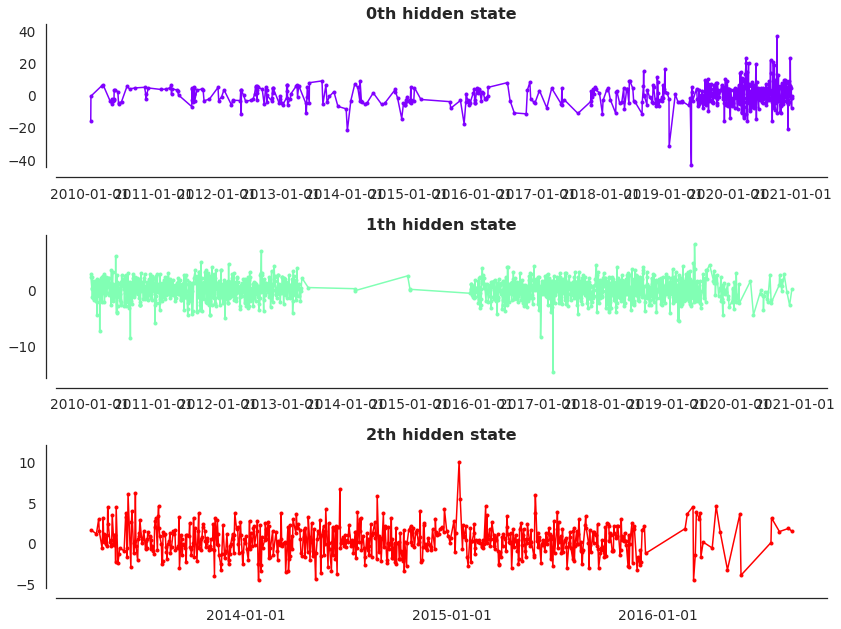

In [173]:
features = ['frac_change', 'frac_high', 'frac_low', 'Close']
col = ['s_return']
X = GEM_data[features].values
model = GMM(n_components=3, 
            covariance_type="full", 
            n_init=100, 
            random_state=10).fit(X)

hidden_states = model.predict(X)

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()
    
sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    ax = plt.subplot(model.n_components, 1, i + 1)
    mask = hidden_states == i
    ax.plot_date(GEM_data.Date.values[mask],
                 GEM_data[col].values[mask],
                 ".-", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')
#     print([GEM_data[col].values[mask].min()*0.8,GEM_data[col].values[mask].max()*1.2])
    ax.set_ylim([GEM_data[col].values[mask].min()-1,GEM_data[col].values[mask].max()*1.2])

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

plt.tight_layout()
#fig.savefig('Hidden Markov (Mixture) Model_Regime Subplots.png')

   states       Date       Open   High        Low      Close    Volume  \
0       1 2010-01-05  22.910000  23.74  22.900000  23.520000   5317400   
1       1 2010-01-06  23.459999  24.10  23.219999  24.030001   5367800   
2       0 2010-01-07  20.010000  21.17  19.420000  20.459999  41190300   
3       0 2010-01-08  20.639999  21.23  20.230000  20.290001  11968100   
4       1 2010-01-11  20.540001  20.59  20.110001  20.320000   7021300   

   frac_change  frac_high  frac_low   s_return   mkt_cret  
0     0.026626   0.036229  0.000437   2.671425   2.671425  
1     0.024297   0.027281  0.010230   2.145194   4.816618  
2     0.022489   0.057971  0.029485 -16.083136 -11.266518  
3    -0.016957   0.028585  0.019864  -0.834352 -12.100869  
4    -0.010711   0.002434  0.020935   0.147741 -11.953129  


Text(0.5, 0.98, 'Historical GEM Regimes')

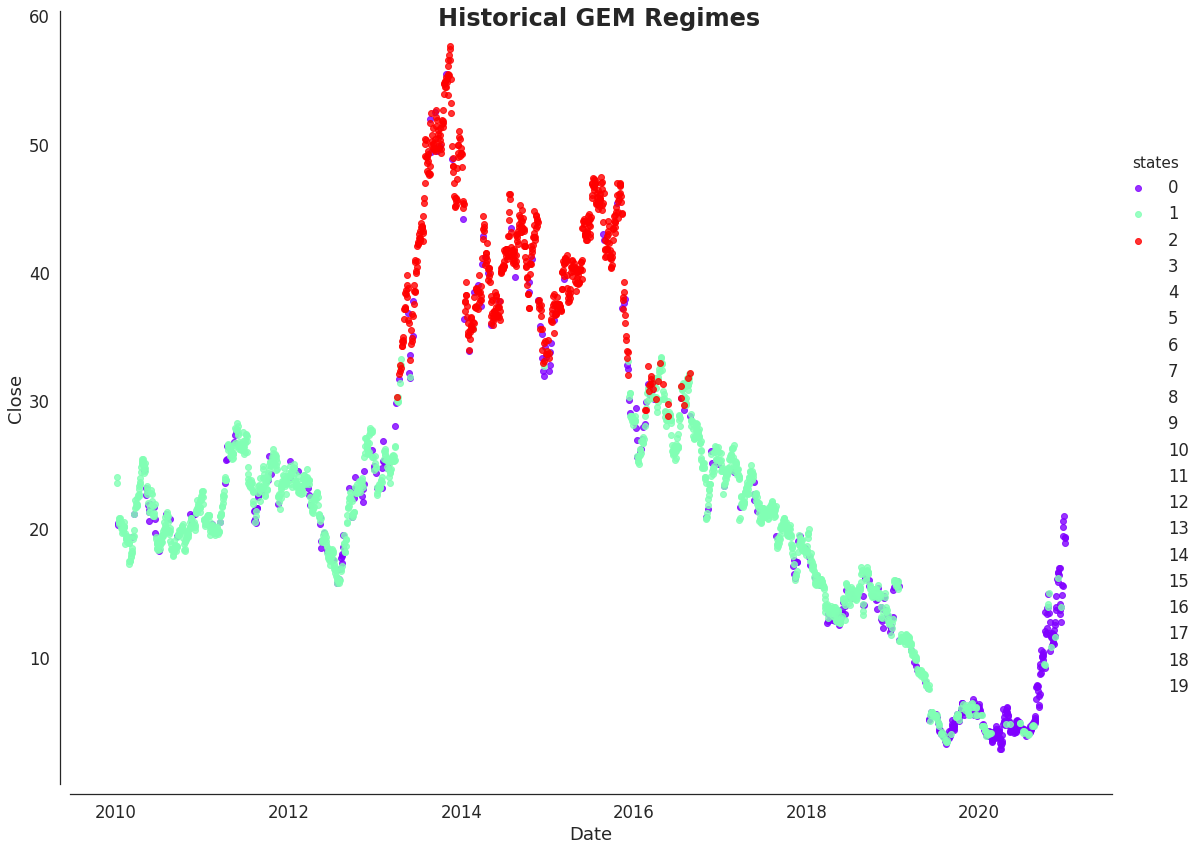

In [174]:
sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states, columns=['states'], index=GEM_data.index)
          .join(GEM_data, how='inner')
          .assign(mkt_cret=GEM_data.s_return.cumsum()))
print(states.head())

sns.set_style('white', style_kwds)
order = list(range(20))
fg = sns.FacetGrid(data=states, hue='states', hue_order=order,
                   palette=colors, aspect=1.31, size=12)
fg.map(plt.scatter, 'Date', 'Close', alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical GEM Regimes', fontsize=24, fontweight='demi')
# fg.savefig('Hidden Markov (Mixture) Model_SPY Regimes.png')

In [150]:
# code sample from:
#   http://www.aizac.info/simple-check-of-a-sample-against-80-distributions/

cdfs = [
    "norm",            #Normal (Gaussian)
    "alpha",           #Alpha
    "anglit",          #Anglit
    "arcsine",         #Arcsine
    "beta",            #Beta
    "betaprime",       #Beta Prime
    "bradford",        #Bradford
    "burr",            #Burr
    "cauchy",          #Cauchy
    "chi",             #Chi
    "chi2",            #Chi-squared
    "cosine",          #Cosine
    "dgamma",          #Double Gamma
    "dweibull",        #Double Weibull
    "erlang",          #Erlang
    "expon",           #Exponential
    "exponweib",       #Exponentiated Weibull
    "exponpow",        #Exponential Power
    "fatiguelife",     #Fatigue Life (Birnbaum-Sanders)
    "foldcauchy",      #Folded Cauchy
    "f",               #F (Snecdor F)
    "fisk",            #Fisk
    "foldnorm",        #Folded Normal
    "frechet_r",       #Frechet Right Sided, Extreme Value Type II
    "frechet_l",       #Frechet Left Sided, Weibull_max
    "gamma",           #Gamma
    "gausshyper",      #Gauss Hypergeometric
    "genexpon",        #Generalized Exponential
    "genextreme",      #Generalized Extreme Value
    "gengamma",        #Generalized gamma
    "genlogistic",     #Generalized Logistic
    "genpareto",       #Generalized Pareto
    "genhalflogistic", #Generalized Half Logistic
    "gilbrat",         #Gilbrat
    "gompertz",        #Gompertz (Truncated Gumbel)
    "gumbel_l",        #Left Sided Gumbel, etc.
    "gumbel_r",        #Right Sided Gumbel
    "halfcauchy",      #Half Cauchy
    "halflogistic",    #Half Logistic
    "halfnorm",        #Half Normal
    "hypsecant",       #Hyperbolic Secant
    "invgamma",        #Inverse Gamma
    "invnorm",         #Inverse Normal
    "invweibull",      #Inverse Weibull
    "johnsonsb",       #Johnson SB
    "johnsonsu",       #Johnson SU
    "laplace",         #Laplace
    "logistic",        #Logistic
    "loggamma",        #Log-Gamma
    "loglaplace",      #Log-Laplace (Log Double Exponential)
    "lognorm",         #Log-Normal
    "lomax",           #Lomax (Pareto of the second kind)
    "maxwell",         #Maxwell
    "mielke",          #Mielke's Beta-Kappa
    "nakagami",        #Nakagami
    "ncx2",            #Non-central chi-squared
#    "ncf",             #Non-central F
    "nct",             #Non-central Student's T
    "norm"           # Normal
    "pareto",          #Pareto
    "powerlaw",        #Power-function
    "powerlognorm",    #Power log normal
    "powernorm",       #Power normal
    "rdist",           #R distribution
    "reciprocal",      #Reciprocal
    "rayleigh",        #Rayleigh
    "rice",            #Rice
    "recipinvgauss",   #Reciprocal Inverse Gaussian
    "semicircular",    #Semicircular
    "t",               #Student's T
    "triang",          #Triangular
    "truncexpon",      #Truncated Exponential
    "truncnorm",       #Truncated Normal
    "tukeylambda",     #Tukey-Lambda
    "uniform",         #Uniform
    "vonmises",        #Von-Mises (Circular)
    "wald",            #Wald
    "weibull_min",     #Minimum Weibull (see Frechet)
    "weibull_max",     #Maximum Weibull (see Frechet)
    "wrapcauchy",      #Wrapped Cauchy
    "ksone",           #Kolmogorov-Smirnov one-sided (no stats)
    "kstwobign"]       #Kolmogorov-Smirnov two-sided test for Large N

sample = GEM_data['s_return'].values
for cdf in cdfs:
    try:
        #fit our data set against every probability distribution
        parameters = eval("scs."+cdf+".fit(sample)");

        #Applying the Kolmogorov-Smirnof one sided test
        D, p = scs.kstest(sample, cdf, args=parameters);

        #pretty-print the results
        D = round(D, 5)
        p = round(p, 5)
        
        #pretty-print the results
        print (cdf.ljust(16) + ("p: "+str(p)).ljust(25)+"D: "+str(D));
    except: continue

norm            p: 0.0                   D: 0.10787
alpha           p: 0.0                   D: 0.12608
anglit          p: 0.0                   D: 0.43466
arcsine         p: 0.0                   D: 0.45574
beta            p: 0.0                   D: 0.10808
betaprime       p: 0.0                   D: 0.31443
bradford        p: 0.0                   D: 0.44354
burr            p: 0.0                   D: 0.66829
cauchy          p: 0.0                   D: 0.04933
chi             p: 0.0                   D: 0.99162
chi2            p: 0.0                   D: 0.09577
cosine          p: 0.0                   D: 0.4285
dgamma          p: 0.03312               D: 0.02715
dweibull        p: 0.00174               D: 0.03561
erlang          p: 0.0                   D: 0.12403
expon           p: 0.0                   D: 0.55205
exponweib       p: 0.0                   D: 0.13063
exponpow        p: 0.0                   D: 0.93278
fatiguelife     p: 0.0                   D: 0.10587
foldcauchy   

In [64]:
def _run_model(df, ft_cols, k, max_iter, init, bgm=None, **kwargs):
    """Function to run mixture model
    
    Params:
        df : pd.DataFrame() 
        ft_cols : list of str() 
        k : int(), n_components
        max_iter : int()
        init : str() {random, kmeans}
    
    Returns:
        model : sklearn model object
        hidden_states : array-like, hidden states
    """
    X = df[ft_cols].values
    
    if bgm:
        model = mix.BayesianGaussianMixture(n_components=k, 
                                            max_iter=max_iter, 
                                            init_params=init,
                                            **kwargs,
                                           ).fit(X)
    else: 
        model = mix.GaussianMixture(n_components=k, 
                                    max_iter=max_iter, 
                                    init_params=init,
                                    **kwargs,
                                   ).fit(X)
    
    hidden_states = model.predict(X)
    return model, hidden_states

In [65]:
def _get_state_est(model, hidden_states):
    """Function to return estimated state mean and state variance
    
    Params:
        model : sklearn model object
        hidden_states : {array-like}
    Returns:
        mr_i : model mean return of last estimated state
        mvar_i : model variance of last estimated state
    """
    # get last state
    last_state = hidden_states[-1]
    # last value is mean return for ith state
    mr_i = model.means_[last_state][-1] 
    mvar_i = np.diag(model.covariances_[last_state])[-1]    
    return mr_i, mvar_i

In [151]:
def _get_ci(mr_i, mvar_i, alpha, a, b, nSamples):
    """Function to sample confidence intervals from the JohnsonSU distribution
    
    Params:
        mr_i : float()
        mvar_i : float()
        alpha : float()
        a : float()
        b : float() 
        nsamples : int()
    Returns:
        ci : tuple(float(), float()), (low_ci, high_ci) 
    """
    np.random.RandomState(0)
    rvs_ = scs.johnsonsu.rvs(a, b, loc=mr_i, scale=mvar_i, size=nSamples)
    ci = scs.johnsonsu.interval(alpha=alpha, a=a, b=b,  loc=np.mean(rvs_), scale=np.std(rvs_))
    return ci

In [152]:
def plot_pred_success(df, year, a, b):
    # colorblind safe palette http://colorbrewer2.org/
    colors = sns.color_palette('RdYlBu', 4)     
    
    fig, ax = plt.subplots(figsize=(10, 7))   
    ax.scatter(df.index, df.tgt, c=[colors[1] if x==1 else colors[0] for x in df['in_rng']], alpha=0.85)
    df['high_ci'].plot(ax=ax, alpha=0.65, marker='.', color=colors[2])
    df['low_ci'].plot(ax=ax, alpha=0.65, marker='.', color=colors[3])
    ax.set_xlim(df.index[0], df.index[-1])
    
    nRight = df.query('in_rng==1').shape[0]
    accuracy = nRight / df.shape[0]    
    ax.set_title(r'cutoff year: {} | accuracy: {:2.3%} | errors: {} | a={}, b={}'
                  .format(year, accuracy, df.shape[0] - nRight, a, b))
    
    in_ = mpl.lines.Line2D(range(1), range(1), color="white", marker='o', markersize=10, markerfacecolor=colors[1])
    out_ = mpl.lines.Line2D(range(1), range(1), color="white", marker='o', markersize=10, markerfacecolor=colors[0])
    hi_ci = mpl.lines.Line2D(range(1), range(1), color="white", marker='.', markersize=15, markerfacecolor=colors[2])
    lo_ci = mpl.lines.Line2D(range(1), range(1), color="white", marker='.', markersize=15, markerfacecolor=colors[3])
    leg = ax.legend([in_, out_, hi_ci, lo_ci],["in", "out", 'high_ci', 'low_ci'],
                    loc = "center left", bbox_to_anchor = (1, 0.85), numpoints = 1)    
    sns.despine(offset=2)
    plt.tight_layout()
    return

In [159]:
%%time

# Model Params
# ------------
a, b = (.1, .5) # found via coarse parameter search
alpha = 0.99
max_iter = 100
k = 2 
init = 'random' #'kmeans'
nSamples = 2_000
ft_cols = ['Open', 'High', 'Low','Volume', 's_return']

years = range(2010,2020)
lookback = 1 # chosen for ease of computation

data = GEM_data.set_index(['Date'])

# Iterate Model
# ------------
for year in years:
    cutoff = year
    train_df = data.loc[str(cutoff - lookback):str(cutoff)].dropna()
    oos = data.loc[str(cutoff+1):].dropna()
    # confirm that train_df end index is different than oos start index
    assert train_df.index[-1] != oos.index[0]
    
    # create pred list to hold tuple rows
    preds = []
    for t in tqdm(oos.index):
        if t == oos.index[0]:
            insample = train_df
            
        # run model func to return model object and hidden states using params
        model, hstates = _run_model(insample, ft_cols, k, max_iter, init, random_state=0)
        # get hidden state mean and variance
        mr_i, mvar_i = _get_state_est(model, hstates)
        # get confidence intervals from sampled distribution
        low_ci, high_ci = _get_ci(mr_i, mvar_i, alpha, a, b, nSamples)
        # append tuple row to pred list
        preds.append((t, hstates[-1], mr_i, mvar_i, low_ci, high_ci))

        # increment insample dataframe
        insample = data.loc[:t] 
          
    break

100%|██████████| 2517/2517 [00:37<00:00, 66.31it/s]

CPU times: user 52.1 s, sys: 1.25 s, total: 53.4 s
Wall time: 38 s


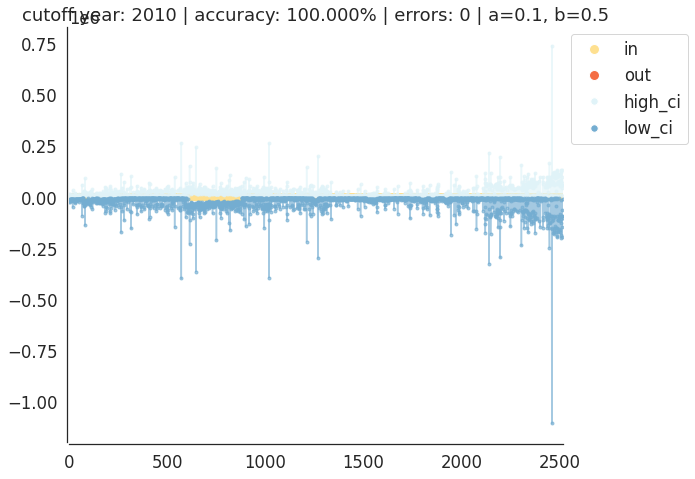

In [160]:
cols = ['ith_state', 'ith_ret', 'ith_var', 'low_ci', 'high_ci']
pred = (pd.DataFrame(preds, columns=['Dates']+cols)
        .set_index('Dates').assign(tgt = oos['s_return']))

# logic to see if error exceeds neg or pos CI
pred_copy = pred.copy().reset_index(drop=True)

# Identify indices where target return falls between CI
win = pred_copy.query("low_ci < tgt < high_ci").index
# create list of binary variables representing in/out CI
in_rng_list = [1 if i in win else 0 for i in pred_copy.index]
# assign binary variables sequence to new column
pred_copy['in_rng'] = in_rng_list

plot_pred_success(pred_copy, year, a, b)

In [118]:
pred_copy

,Dates,ith_state,ith_ret,ith_var,low_ci,high_ci,tgt
0,2011-01-03,1,-0.194969,4.015352,-5.792162e+26,3.642328e+29,0.131036
1,2011-01-04,1,-0.191850,3.992878,-4.978358e+21,3.130578e+24,-1.805818
2,2011-01-05,1,-0.199240,3.987095,-8.567510e+22,5.387571e+25,-2.748543
3,2011-01-06,1,-0.212795,4.000158,-2.506196e+22,1.575990e+25,-5.928360
4,2011-01-07,1,-0.246371,4.151627,-7.514916e+27,4.725661e+30,0.676337
...,...,...,...,...,...,...,...
2512,2020-12-24,1,0.007082,45.907538,-7.173135e+26,4.510736e+29,-2.062942
2513,2020-12-28,1,0.002660,45.796456,-8.506102e+26,5.348956e+29,4.084185
2514,2020-12-29,1,0.010275,45.707513,-2.863702e+20,1.800803e+23,-7.980456
2515,2020-12-30,1,-0.003321,45.756892,-6.421426e+24,4.038033e+27,-0.621114
